# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.90KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

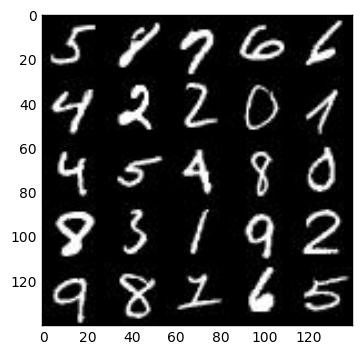

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

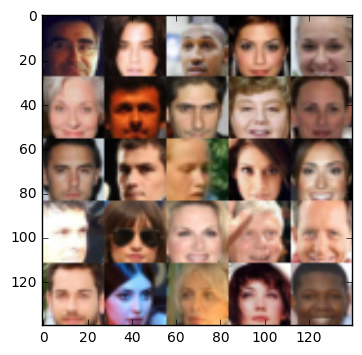

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
def leaky_relu(x, alpha=0.05, name='leaky_relu'): 
   return tf.maximum(x, alpha * x, name=name)

In [44]:
def discriminator(images, reuse=False, drop_rate=0.3, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.dropout(x1, rate=drop_rate, training=True)
        x1 = leaky_relu(x1,alpha)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.dropout(x2, rate=drop_rate, training=True)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2,alpha)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.dropout(x3, rate=drop_rate, training=True)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3,alpha)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
def generator(z, out_channel_dim, is_train=True, drop_rate=0.3, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse_state = not is_train

    with tf.variable_scope('generator',reuse=reuse_state): 
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1,(-1,4,4,512))
        x1 = x1 = leaky_relu(x1,alpha)    
        
        x2 = tf.layers.conv2d_transpose(x1, 256 , 4,strides = 1, padding= 'valid',kernel_initializer=tf.contrib.layers.xavier_initializer() )
        x2 = tf.layers.dropout(x2, rate=drop_rate, training=is_train)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2,alpha)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides= 2, padding= 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.dropout(x3, rate=drop_rate, training=is_train)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3,alpha)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides= 2, padding= 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())    
        out = tf.tanh(logits)
        
        return out
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
 
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 2.9051
Epoch 1/2... Discriminator Loss: 5.1189... Generator Loss: 15.3914
Epoch 1/2... Discriminator Loss: 0.6867... Generator Loss: 2.4401
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 1.0508


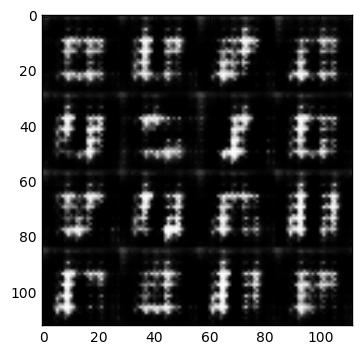

Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 1.9963
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.6347
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 2.0394... Generator Loss: 1.9857
Epoch 1/2... Discriminator Loss: 1.2796... Generator Loss: 0.9519


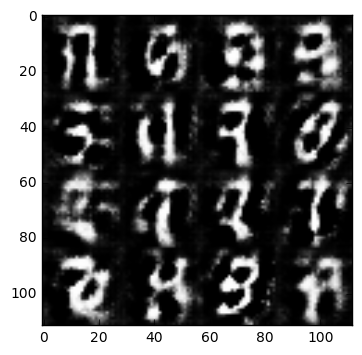

Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 0.6360


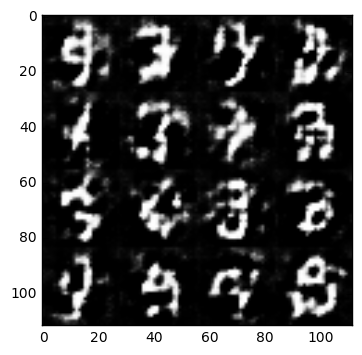

Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 0.9609
Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.8493
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 1.0989


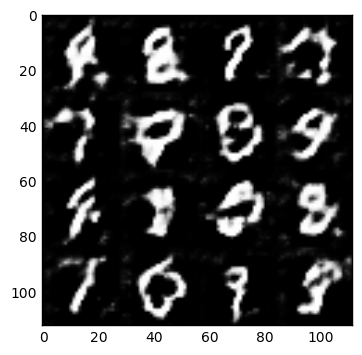

Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 1.0327
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 1.2366


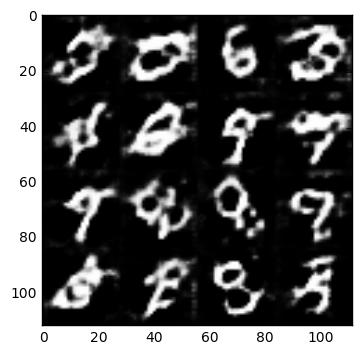

Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 1.1798
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 0.9035
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 0.8243


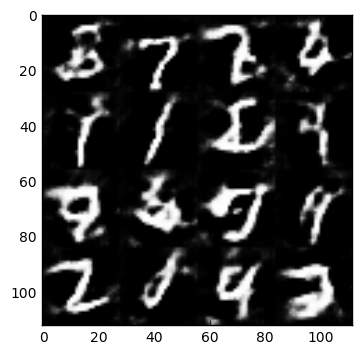

Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 1.0028
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 1.1144
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.8660


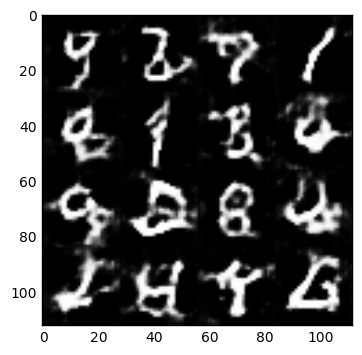

Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.6711
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 1.0978
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 0.8118
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.8292


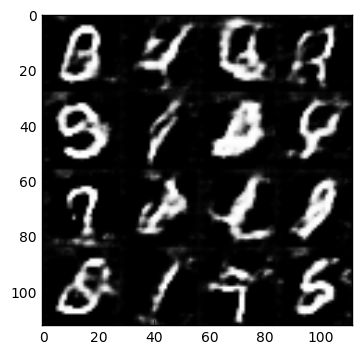

Epoch 1/2... Discriminator Loss: 1.5590... Generator Loss: 1.5804
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.8694
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 1.4734
Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 1.2470


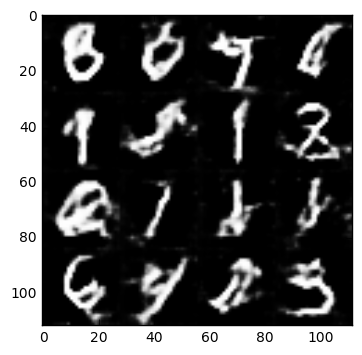

Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 1.2391
Epoch 1/2... Discriminator Loss: 1.3206... Generator Loss: 0.6275
Epoch 2/2... Discriminator Loss: 1.6673... Generator Loss: 2.4590
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.4704
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 1.0463


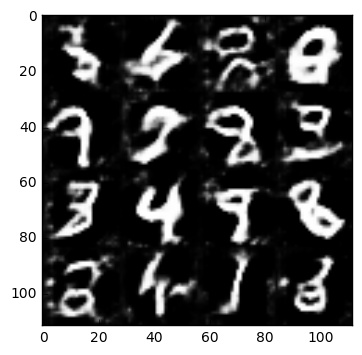

Epoch 2/2... Discriminator Loss: 1.6773... Generator Loss: 2.4426
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 0.5388
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 1.7777
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 1.2718


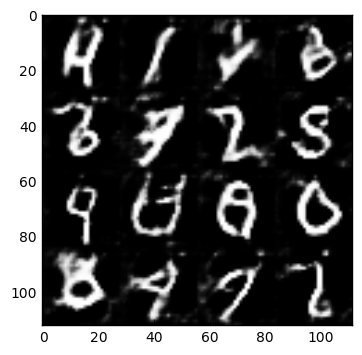

Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 1.7233
Epoch 2/2... Discriminator Loss: 1.1282... Generator Loss: 1.1085
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.5619
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.2637


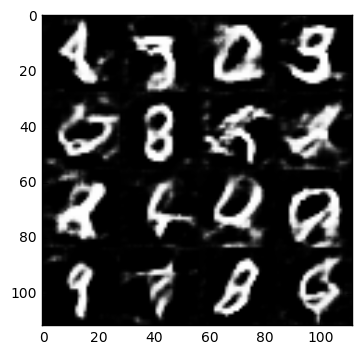

Epoch 2/2... Discriminator Loss: 1.1399... Generator Loss: 0.8906
Epoch 2/2... Discriminator Loss: 1.1700... Generator Loss: 0.9461
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 2.1080
Epoch 2/2... Discriminator Loss: 0.9966... Generator Loss: 1.1912
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 0.9464


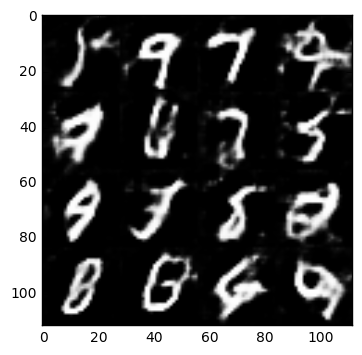

Epoch 2/2... Discriminator Loss: 1.4772... Generator Loss: 0.5394
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 1.6153
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 2.1447
Epoch 2/2... Discriminator Loss: 1.1744... Generator Loss: 0.6539
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.9972


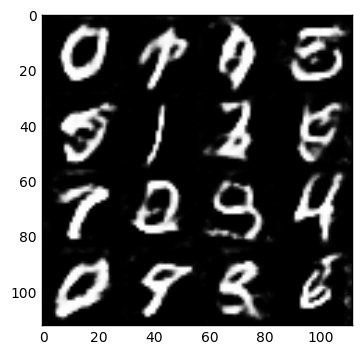

Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 1.9923
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.5618
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 1.5648


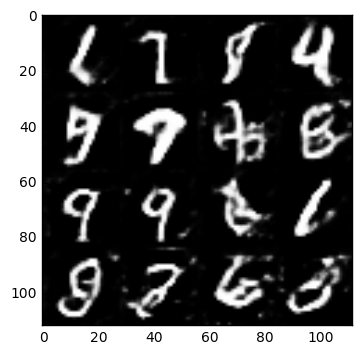

Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 1.9045
Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 0.9415
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 1.9701
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 1.1078


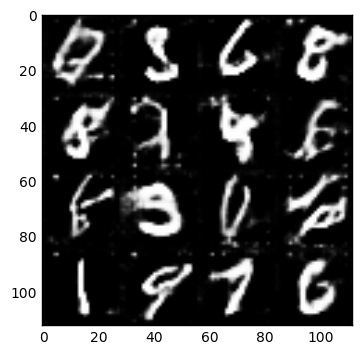

Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 2.1580
Epoch 2/2... Discriminator Loss: 1.0287... Generator Loss: 0.9614
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 1.4725
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 1.1898
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.2974


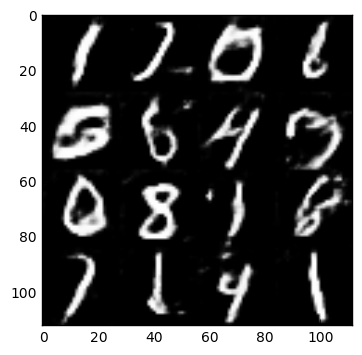

Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.1674
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 1.0377
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 2.4334
Epoch 2/2... Discriminator Loss: 2.7595... Generator Loss: 4.0779


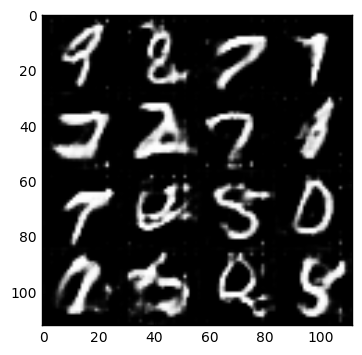

Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 0.9362


In [50]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1052... Generator Loss: 0.3253
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.5208


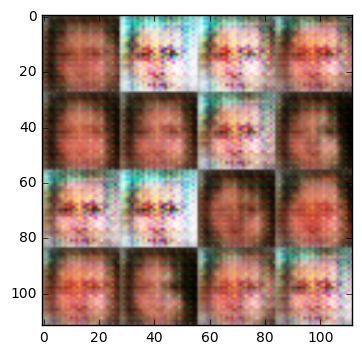

Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 2.3853
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8400


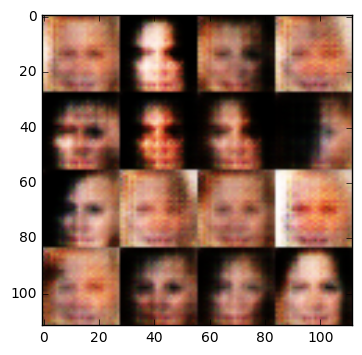

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 2.0797... Generator Loss: 0.3293
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 2.7671... Generator Loss: 2.7629


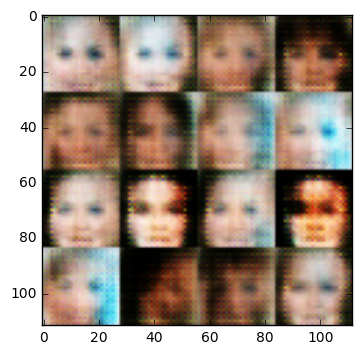

Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 2.0596
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.9232


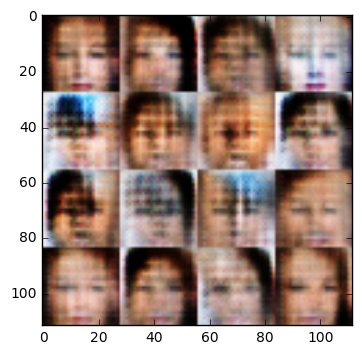

Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 1.0081


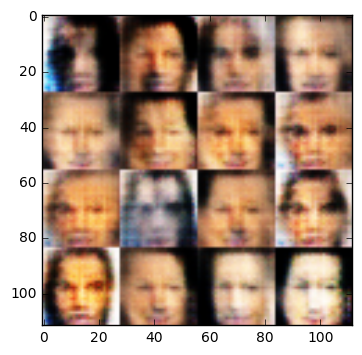

Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.9400... Generator Loss: 0.2791


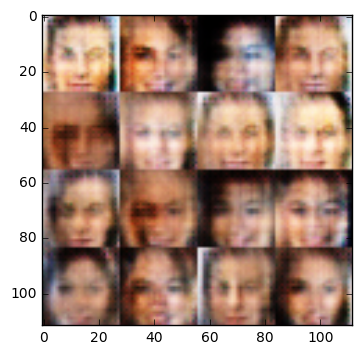

Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7572


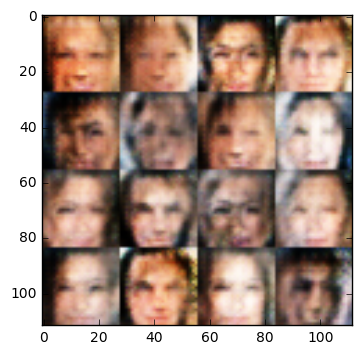

Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 1.3854
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.6303


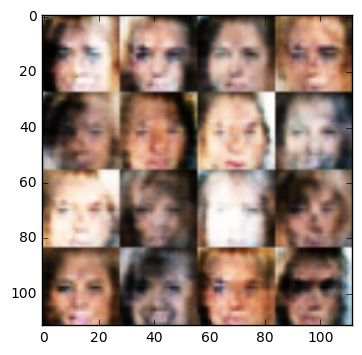

Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.9030


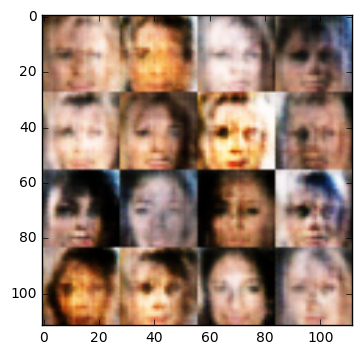

Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7311


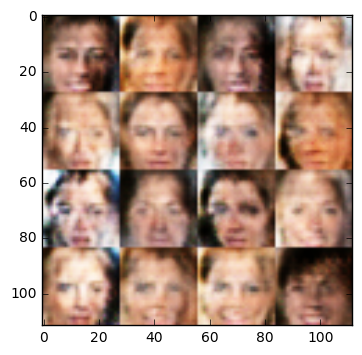

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 1.3813
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.9885


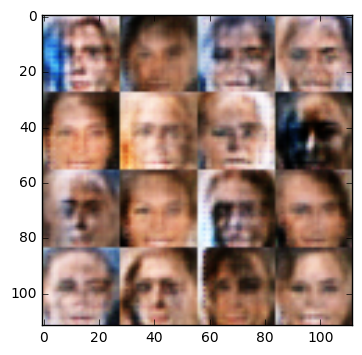

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.5480


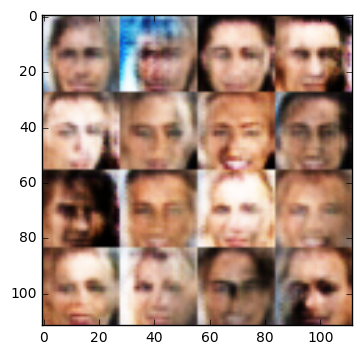

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 1.0927


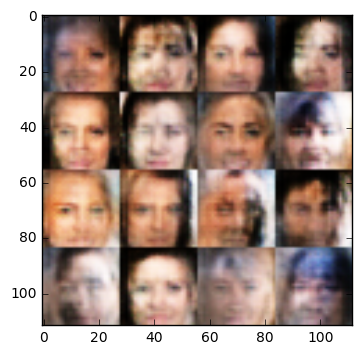

Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.8258


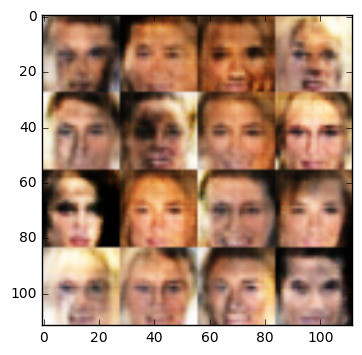

Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.9884


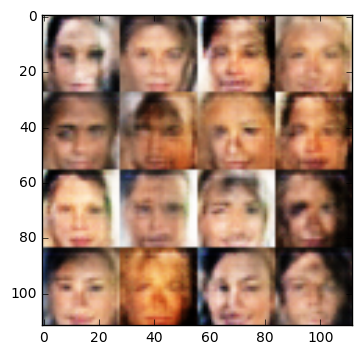

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.5873


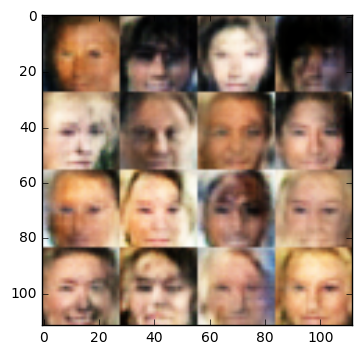

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 1.0632


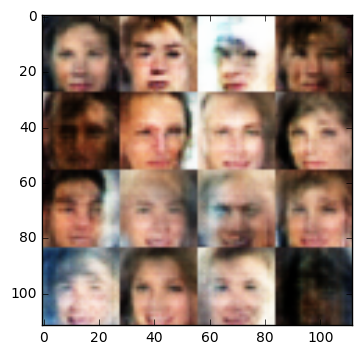

Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8818


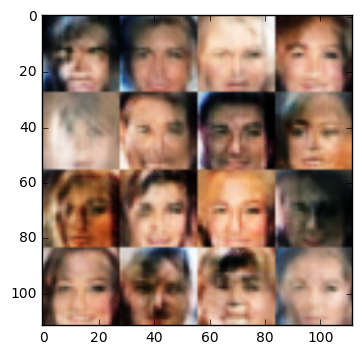

Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.0283


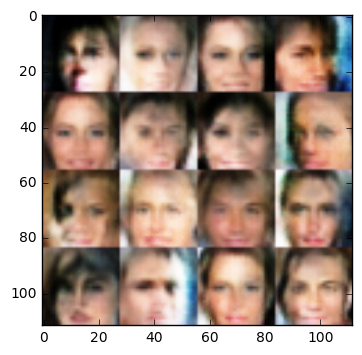

Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.5258


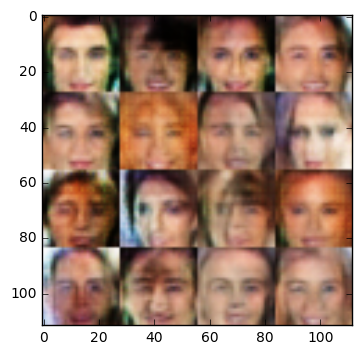

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6310


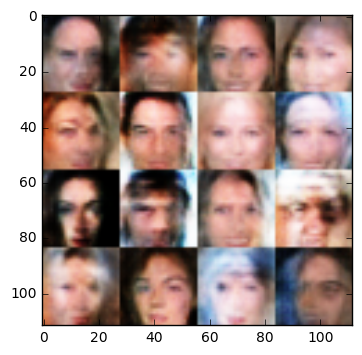

Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8141


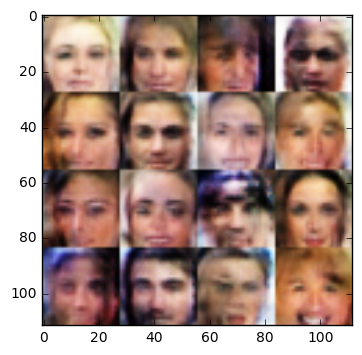

Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.4897


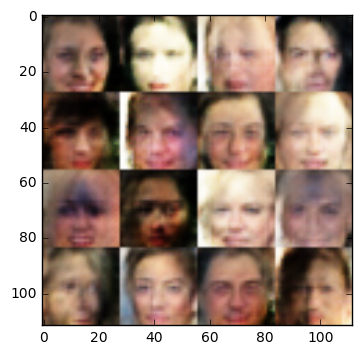

Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8560


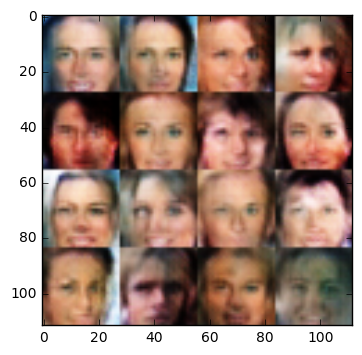

Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.2279
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.8113


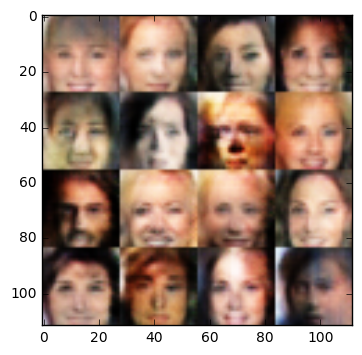

Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5417


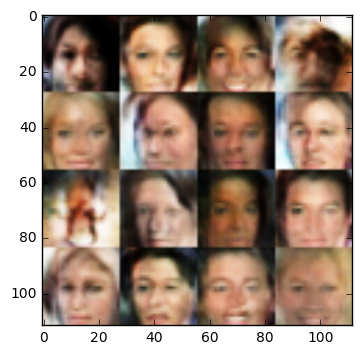

Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7829


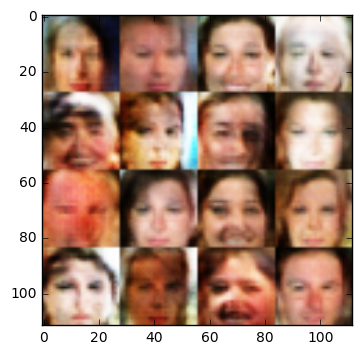

Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 1.1094


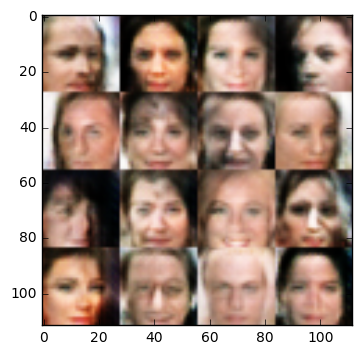

Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.8035


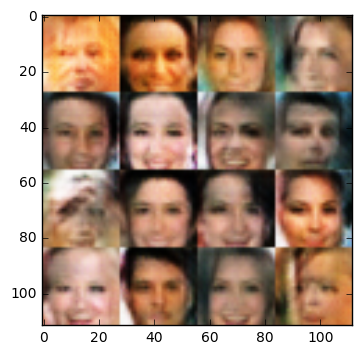

Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7274


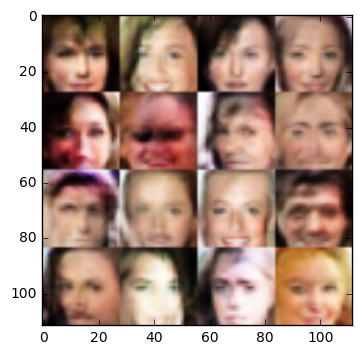

Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7377


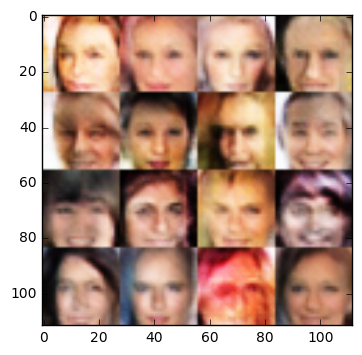

Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8959


In [51]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.